# Expert model setup

In [1]:
!pip install huggingface_hub
!pip install dghs-imgutils
!pip install hbutils>=0.9.1
# opencv-python
# numpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
zsh:1: 0.9.1 not found


In [2]:
import cv2
import os.path
import numpy as np
from tqdm import tqdm
from typing import List, Tuple
from functools import lru_cache
from imgutils.data import ImageTyping
from imgutils.utils import open_onnx_model
from imgutils.detect import detection_visualize
from huggingface_hub import HfApi, HfFileSystem, hf_hub_download

In [3]:
hf_client = HfApi()
hf_fs = HfFileSystem()


@lru_cache()
def _get_available_models():
    for f in hf_fs.glob('deepghs/text_detection/*/end2end.onnx'):
        yield os.path.relpath(f, 'deepghs/text_detection').split('/')[0]


_ALL_MODELS = list(_get_available_models())
_DEFAULT_MODEL = 'dbnetpp_resnet50_fpnc_1200e_icdar2015'


@lru_cache()
def _get_onnx_session(model):
    return open_onnx_model(hf_hub_download(
        'deepghs/text_detection',
        f'{model}/end2end.onnx'
    ))


def _get_heatmap_of_text(image: ImageTyping, model: str) -> np.ndarray:
    origin_width, origin_height = width, height = image.size
    align = 32
    if width % align != 0:
        width += (align - width % align)
    if height % align != 0:
        height += (align - height % align)

    input_ = np.array(image).transpose((2, 0, 1)).astype(np.float32) / 255.0
    # noinspection PyTypeChecker
    input_ = np.pad(input_[None, ...], ((0, 0), (0, 0), (0, height - origin_height), (0, width - origin_width)))

    def _normalize(data, mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)):
        mean, std = np.asarray(mean), np.asarray(std)
        return (data - mean[None, :, None, None]) / std[None, :, None, None]

    ort = _get_onnx_session(model)

    input_ = _normalize(input_).astype(np.float32)
    output_, = ort.run(['output'], {'input': input_})
    heatmap = output_[0]
    heatmap = heatmap[:origin_height, :origin_width]

    return heatmap


def _get_bounding_box_of_text(image: ImageTyping, model: str, threshold: float) \
        -> List[Tuple[Tuple[int, int, int, int], float]]:
    heatmap = _get_heatmap_of_text(image, model)
    c_rets = cv2.findContours((heatmap * 255.0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = c_rets[0] if len(c_rets) == 2 else c_rets[1]
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x0, y0, x1, y1 = x, y, x + w, y + h
        score = heatmap[y0:y1, x0:x1].mean().item()
        if score >= threshold:
            bboxes.append(((x0, y0, x1, y1), score))

    return bboxes


def detect_text(image: ImageTyping, model: str = _DEFAULT_MODEL, threshold: float = 0.05):
    bboxes = []
    for (x0, y0, x1, y1), score in _get_bounding_box_of_text(image, model, threshold):
        bboxes.append(((x0, y0, x1, y1), 'text', score))
    return bboxes

In [4]:
from PIL import Image

image_path = f'./findit2/torchdataset/val/1/X51006555125.png'

# Load the original image
image = Image.open(image_path).convert('RGB')

In [5]:
model = _DEFAULT_MODEL
threshold = 0.05

In [6]:
detect_text(image, model, threshold)

[((385, 957, 446, 977), 'text', 0.3020177185535431),
 ((260, 955, 383, 978), 'text', 0.25570428371429443),
 ((206, 955, 253, 974), 'text', 0.3339923620223999),
 ((136, 955, 202, 975), 'text', 0.36037278175354004),
 ((144, 929, 208, 946), 'text', 0.45202651619911194),
 ((260, 928, 444, 946), 'text', 0.3704589903354645),
 ((210, 928, 256, 946), 'text', 0.4093862473964691),
 ((476, 768, 518, 788), 'text', 0.11564274877309799),
 ((117, 766, 156, 788), 'text', 0.37624993920326233),
 ((57, 766, 85, 786), 'text', 0.21058867871761322),
 ((297, 765, 364, 785), 'text', 0.3886224031448364),
 ((108, 738, 200, 761), 'text', 0.20390766859054565),
 ((235, 736, 360, 754), 'text', 0.3995518684387207),
 ((430, 734, 518, 758), 'text', 0.18109075725078583),
 ((60, 730, 96, 754), 'text', 0.08608300238847733),
 ((500, 696, 552, 716), 'text', 0.153787299990654),
 ((270, 695, 357, 711), 'text', 0.45703378319740295),
 ((498, 664, 554, 685), 'text', 0.3758138120174408),
 ((271, 662, 330, 681), 'text', 0.4527332

In [7]:
_DEFAULT_MODEL

'dbnetpp_resnet50_fpnc_1200e_icdar2015'

# Forgery detection model setup

In [8]:
import os
import ast
import torch
import torchvision
import pandas as pd
from torchvision import models, transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from skimage.transform import resize
import matplotlib.pyplot as plt

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
# Preprocessing: Convert bounding boxes to segmentation masks
def create_mask_from_bboxes(image_shape, annotations, detected_texts, num_classes):
    mask = Image.new('I', image_shape, 0)  # 'I' for integer mode
    draw = ImageDraw.Draw(mask)
    
#     # Example mapping, adjust according to your 'Entity type'
#     class_mapping = {'Forgery': 1}
    for box in detected_texts:
        draw.rectangle([box[0][0], box[0][1], box[0][2], box[0][3]], fill=1)
    
    if annotations != 0:
        for ann in annotations["regions"]:
            bbox = ann['shape_attributes']
            draw.rectangle([bbox['x'], bbox['y'], bbox['x'] + bbox['width'], bbox['y'] + bbox['height']], fill=2)
    
    # Ensure the mask is in the correct format for training
    mask = np.array(mask)
    mask = np.clip(mask, 0, num_classes-1)  # Ensure mask values are within [0, num_classes-1]
    return mask

In [10]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        # Set a common size for all images and masks
        self.resize = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations.iloc[idx]
        image_path = os.path.join(self.image_dir, ann['image'])
        image = Image.open(image_path).convert('RGB')
        mask = create_mask_from_bboxes(image.size, ann["forgery annotations"], 
                                       ann["detected_texts"], num_classes=3)
        
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        
        mask = np.array(mask, dtype=np.int64)  # Ensure mask is an integer type
        mask = torch.tensor(mask).squeeze(0)

        return image, mask

In [11]:
df = {}
for mode in ["train", "val", "test"]:
    df[mode] = pd.read_csv(f"./findit2/{mode}.txt")
    df[mode]["forgery annotations"] = df[mode]["forgery annotations"].map(ast.literal_eval)

## Generate auxiliary labels using expert model

In [12]:
def populate_text_detections(image_path):
    image = Image.open(image_path).convert('RGB')
    detected_texts = detect_text(image, _DEFAULT_MODEL, threshold)
    detected_texts_copy = []
    for i in range(len(detected_texts)):
        width = detected_texts[i][0][2] - detected_texts[i][0][0]
        height = detected_texts[i][0][3] - detected_texts[i][0][1]
        x1 = max(0, detected_texts[i][0][0]- int(0.1*width))
        x2 = min(image.size[0]-1, detected_texts[i][0][2]+ int(0.1*width))
        y1 = max(0, detected_texts[i][0][1]- int(0.4*height))
        y2 = min(image.size[1]-1, detected_texts[i][0][3]+ int(0.4*height))
        detected_texts_copy.append(((x1, y1, x2, y2), "text", detected_texts[i][2]))
    return detected_texts_copy

In [13]:
tqdm.pandas()

for k in df:
    df[k]["detected_texts"] = (f"./findit2/{k}/" + df[k]["image"]).progress_map(populate_text_detections)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [17:52<00:00,  4.92s/it]


## Instantiate PyTorch datasets and dataloaders

In [14]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),

])

# Example annotations list (your dataset)
annotations = df["train"]

# Initialize dataset
tr_dataset = SegmentationDataset("./findit2/train", df["train"], transform=transform)
va_dataset = SegmentationDataset("./findit2/val", df["val"], transform=transform)
te_dataset = SegmentationDataset("./findit2/test", df["test"], transform=transform)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, drop_last=True)
va_dataloader = DataLoader(va_dataset, batch_size=4, shuffle=True, drop_last=True)
te_dataloader = DataLoader(te_dataset, batch_size=4, shuffle=True, drop_last=True)

## Define model

In [15]:
# Model
model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


class_frequencies = [1.2, 1.05, 1]  # Example frequencies for three classes

# Calculate weights
weights = 1.0 / torch.tensor(class_frequencies, dtype=torch.float32)


# Training essentials
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss(weight=weights)

/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Ashish.Jha/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training model

In [16]:
# Training loop
num_epochs = 50  # Example, adjust as needed
tr_loss = []
va_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(tr_dataloader):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    tr_loss.append(running_loss / len(tr_dataloader))
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in va_dataloader:
            images, masks = images.to(device), masks.to(device)
            output = model(images)['out']
            loss = loss_function(output, masks)
            val_loss += loss.item()
    va_loss.append(val_loss / len(va_dataloader))
    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(tr_dataloader)}, Val Loss: {val_loss / len(va_dataloader)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:04<00:00,  1.28s/it]


Epoch 1, Train Loss: 0.6313223530434899, Val Loss: 0.5096593213578066


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:53<00:00,  1.20s/it]


Epoch 2, Train Loss: 0.41839938341743416, Val Loss: 0.41386847229053575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:02<00:00,  1.27s/it]


Epoch 3, Train Loss: 0.37171901959098047, Val Loss: 0.3885929798707366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:40<00:00,  1.11s/it]


Epoch 4, Train Loss: 0.3445558782873882, Val Loss: 0.36233777180314064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:00<00:00,  1.25s/it]


Epoch 5, Train Loss: 0.32694166857335305, Val Loss: 0.3475279165431857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:05<00:00,  1.29s/it]


Epoch 6, Train Loss: 0.3175430553447869, Val Loss: 0.3401585627968113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:55<00:00,  1.22s/it]


Epoch 7, Train Loss: 0.3107957211840484, Val Loss: 0.3340095852812131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:55<00:00,  1.22s/it]


Epoch 8, Train Loss: 0.3049302004898588, Val Loss: 0.33664307929575443


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:56<00:00,  1.22s/it]


Epoch 9, Train Loss: 0.30445473330716294, Val Loss: 0.33329615121086437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:06<00:00,  1.30s/it]


Epoch 10, Train Loss: 0.2948627970698807, Val Loss: 0.3287455237781008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:13<00:00,  1.35s/it]


Epoch 11, Train Loss: 0.2914541464092003, Val Loss: 0.3279729938755433


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [53:13<00:00, 22.18s/it]


Epoch 12, Train Loss: 0.2895759767335322, Val Loss: 0.3329892760763566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:08<00:00,  1.31s/it]


Epoch 13, Train Loss: 0.28467760390291613, Val Loss: 0.32486785637835663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:04<00:00,  1.28s/it]


Epoch 14, Train Loss: 0.28327065364768106, Val Loss: 0.32618157907078665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:02<00:00,  1.27s/it]


Epoch 15, Train Loss: 0.2804501340207126, Val Loss: 0.32638320202628773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:02<00:00,  1.26s/it]


Epoch 16, Train Loss: 0.2792393360286951, Val Loss: 0.32463686106105644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:00<00:00,  1.25s/it]


Epoch 17, Train Loss: 0.27762055459121865, Val Loss: 0.323327489507695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:03<00:00,  1.28s/it]


Epoch 18, Train Loss: 0.27538612205535173, Val Loss: 0.3221779850622018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:01<00:00,  1.26s/it]


Epoch 19, Train Loss: 0.2742413704076575, Val Loss: 0.3226548594733079


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:01<00:00,  1.26s/it]


Epoch 20, Train Loss: 0.2721812648491727, Val Loss: 0.32387951606263715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:05<00:00,  1.29s/it]


Epoch 21, Train Loss: 0.2716735503118899, Val Loss: 0.32140624709427357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:59<00:00,  1.25s/it]


Epoch 22, Train Loss: 0.27034875967850286, Val Loss: 0.3223971103628476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:59<00:00,  1.25s/it]


Epoch 23, Train Loss: 0.26959362708859974, Val Loss: 0.3262529466301203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:56<00:00,  1.22s/it]


Epoch 24, Train Loss: 0.2694634662216736, Val Loss: 0.3215041117121776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:16<00:00,  1.36s/it]


Epoch 25, Train Loss: 0.26778191503965193, Val Loss: 0.32695178128778934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:15<00:00,  1.36s/it]


Epoch 26, Train Loss: 0.26623418275266886, Val Loss: 0.32689073712875444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:05<00:00,  1.29s/it]


Epoch 27, Train Loss: 0.26553340990924174, Val Loss: 0.3238204900796215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:08<00:00,  1.31s/it]


Epoch 28, Train Loss: 0.26470268248683876, Val Loss: 0.3235690106327335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:18<00:00,  1.38s/it]


Epoch 29, Train Loss: 0.2636557868681848, Val Loss: 0.3228118351350228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:29<00:00,  1.46s/it]


Epoch 30, Train Loss: 0.2642818595179253, Val Loss: 0.3242326636488239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:14<00:00,  1.35s/it]


Epoch 31, Train Loss: 0.26225020612279576, Val Loss: 0.32296602816010517


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:13<00:00,  1.35s/it]


Epoch 32, Train Loss: 0.2605416448786855, Val Loss: 0.32456120538214844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:16<00:00,  1.37s/it]


Epoch 33, Train Loss: 0.26036654019521344, Val Loss: 0.3233256734286745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:24<00:00,  1.42s/it]


Epoch 34, Train Loss: 0.25971373077481985, Val Loss: 0.324589731482168


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:27<00:00,  1.44s/it]


Epoch 35, Train Loss: 0.25968874815023607, Val Loss: 0.3232310215632121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:18<00:00,  1.38s/it]


Epoch 36, Train Loss: 0.2588364254269335, Val Loss: 0.3227990459029873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [03:09<00:00,  1.32s/it]


Epoch 37, Train Loss: 0.25818644194967216, Val Loss: 0.3265562898789843


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 38, Train Loss: 0.25807651246173513, Val Loss: 0.32428741610298556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:50<00:00,  1.18s/it]


Epoch 39, Train Loss: 0.2569941046337287, Val Loss: 0.32502368930727243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:47<00:00,  1.16s/it]


Epoch 40, Train Loss: 0.2589943260471854, Val Loss: 0.3262074862917264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:39<00:00,  1.11s/it]


Epoch 41, Train Loss: 0.2576073590252135, Val Loss: 0.32499311833331984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:56<00:00,  1.22s/it]


Epoch 42, Train Loss: 0.2565998990709583, Val Loss: 0.3251269223789374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 43, Train Loss: 0.26773399694098365, Val Loss: 0.35128804420431453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:46<00:00,  1.15s/it]


Epoch 44, Train Loss: 0.26482885361959535, Val Loss: 0.3239575245728095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 45, Train Loss: 0.2588792623848551, Val Loss: 0.32436366255084675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:39<00:00,  1.11s/it]


Epoch 46, Train Loss: 0.2556283350309564, Val Loss: 0.3229367711270849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:46<00:00,  1.16s/it]


Epoch 47, Train Loss: 0.254866957043608, Val Loss: 0.32446180656552315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:45<00:00,  1.15s/it]


Epoch 48, Train Loss: 0.25341728960888255, Val Loss: 0.3247406668961048


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:42<00:00,  1.13s/it]


Epoch 49, Train Loss: 0.2531223228822152, Val Loss: 0.32582724497963983


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:45<00:00,  1.15s/it]


Epoch 50, Train Loss: 0.25320575753640795, Val Loss: 0.3257999022801717


## Evaluate model performance

In [29]:
def compute_iou(pred, target, threshold):
    pred = (pred > threshold).float()
    intersection = torch.logical_and(pred, target).float().sum((1, 2))
    union = torch.logical_or(pred, target).float().sum((1, 2))
    iou = (intersection / union)
    return iou.mean().item()

# Test set evaluation
test_loss = 0.0
iou_scores_set = []
threshold_range = np.arange(0, 1.01, 0.01)
model.eval()
with torch.no_grad():
    for images, masks in tqdm(te_dataloader):
        images, masks = images.to(device), masks.to(device)
        output = model(images)['out']
        loss = loss_function(output, masks)
        test_loss += loss.item()
        iou_scores = []
        output = torch.sigmoid(output)[:, 2, :, :]  # Apply sigmoid to get probabilities and select forged class
        for threshold in threshold_range:
            iou = compute_iou(output, masks, threshold)
            iou_scores.append(iou)
        iou_scores_set.append(iou_scores)

avg_iou = np.mean(iou_scores_set, axis=0)

print(f'Test Loss: {test_loss / len(te_dataloader)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:52<00:00,  1.02it/s]

Test Loss: 0.3070066311845073


### Plot train,validation and test losses

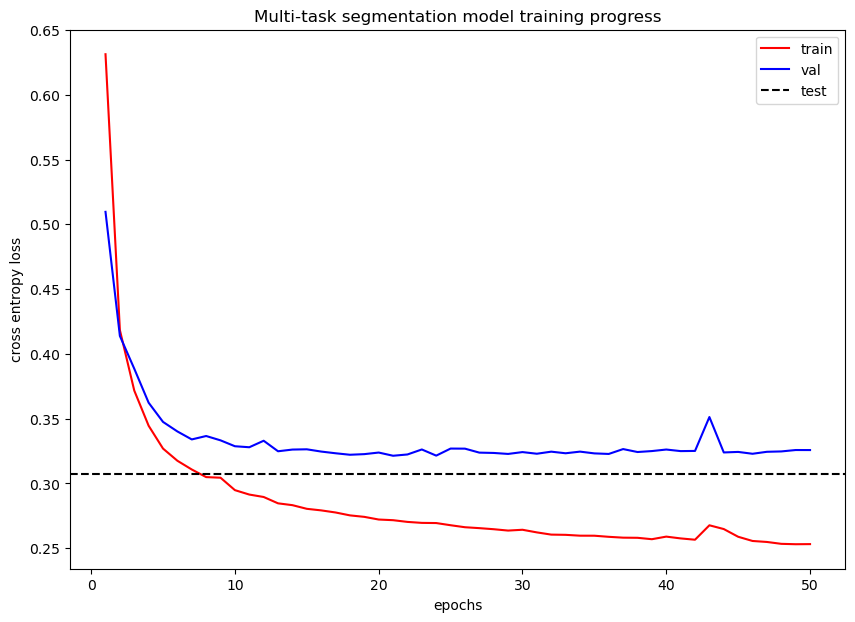

In [30]:
plt.figure(figsize=(10,7))
# Define the epochs and losses
epochs = list(range(1, 51))
plt.plot(epochs, tr_loss, 'r', label='train')
plt.plot(epochs, va_loss, 'b', label='val')
plt.axhline(test_loss / len(te_dataloader), color='black', linestyle='--', label='test') 
plt.ylabel("cross entropy loss")
plt.xlabel("epochs")
plt.title("Multi-task segmentation model training progress")
plt.legend()

### Plot IoU on test set

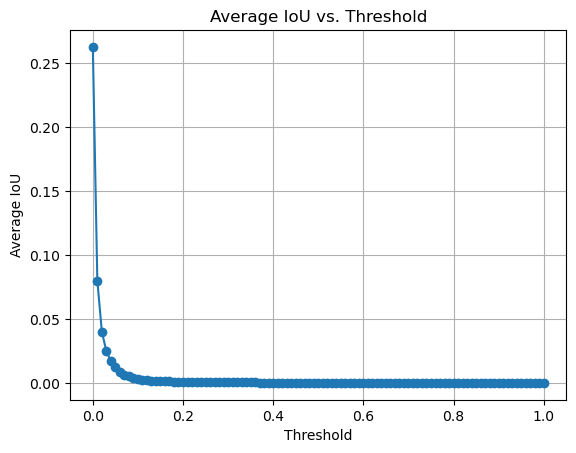

In [31]:
# Plotting the IoU curve
plt.plot(threshold_range, avg_iou, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Average IoU')
plt.title('Average IoU vs. Threshold')
plt.grid(True)
plt.show()

## Interpret model predictions

In [19]:
mode = "test"

transform = T.Compose([
    T.Resize((256, 256)),
    # Don't convert to tensor yet to facilitate visualization steps
])

image_path = f'./findit2/torchdataset/test/1/X51005568866.png'
## image_path = f'./findit2/torchdataset/test/1/X51005757243.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557117.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557195.png'
# image_path = f'./findit2/torchdataset/train/1/X51005365179.png'

# image_path = f'./findit2/torchdataset/test/0/X00016469619.png'

# Load the original image
original_image = Image.open(image_path).convert('RGB')
original_size = original_image.size  # Width, Height

# Apply the same transformations as during training (excluding ToTensor)
transformed_image = transform(original_image)  # Resized image

In [20]:
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    input_tensor = T.functional.to_tensor(transformed_image).unsqueeze(0).to(device)  # Add batch dimension and transfer to GPU
    output = model(input_tensor)['out']
    predictions = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()  # Convert to numpy array for visualization

In [21]:
predictions_prob = torch.softmax(output, dim=1)[0][2]

In [22]:
# Resize predictions back to the original image size
predictions_resized = resize(predictions_prob, (original_size[1], original_size[0]), 
                             order=0, preserve_range=True, anti_aliasing=False)


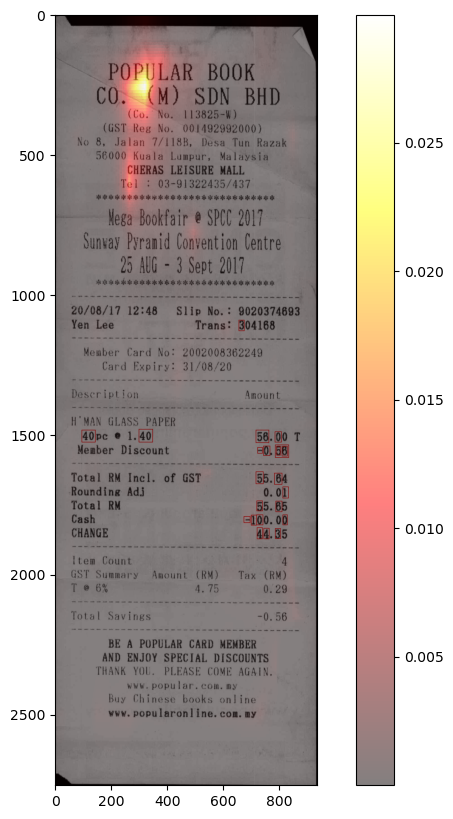

In [23]:
def draw_bounding_boxes(image, annotations):
    draw = ImageDraw.Draw(image)
    for ann in annotations.get('regions', []):
        shape_attr = ann['shape_attributes']
        x, y, w, h = shape_attr['x'], shape_attr['y'], shape_attr['width'], shape_attr['height']
        draw.rectangle([(x, y), (x+w, y+h)], outline="red", width=2)
    return image

annotations = df[mode][df[mode]["image"]==image_path.split("/")[-1]]["forgery annotations"].iloc[0]
if annotations ==0: 
    annotations={}

# Load the original image without resizing to maintain original dimensions for visualization
original_image = Image.open(image_path).convert('RGB')
drawn_image = draw_bounding_boxes(original_image, annotations)  # Assume 'annotations' is defined

# Convert drawn image to array for overlaying
import numpy as np
drawn_image_array = np.array(drawn_image)

# Create a figure to display the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Display original image
ax.imshow(drawn_image_array)
# Overlay heatmap (You may need to adjust the alpha for better visualization)
heatmap = ax.imshow(predictions_resized, cmap='hot', interpolation='nearest', alpha=0.5)
plt.colorbar(heatmap)
plt.show()